# medeiros_STORM_analysis

Notebook for STORM analysis for Medeiros, et al., 2023.

In [21]:
# Data locations

dataset_num = 0

if dataset_num==0:
    dbscan_file = '20220517_L1_NMJ1_A3R67_DBSCAN_v2.xlsx'
    dbscan_sheet = 'B1_DBSCAN'
    max_proj_file = 'MAX_20220517_CacHalo_JF646_L1_A3R67_001.png'
else:
    dbscan_file = '20220517_L1_NMJ2_A4R67b_DBSCAN_v2.xlsx'
    dbscan_sheet = 'B1_DBSCAN'
    max_proj_file = 'MAX_20220517_CacHalo_JF646_L1_A4R67b_005.png'

## Initialize

In [2]:
# Imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# CGAL package for point->shape analysis
from CGAL.CGAL_Kernel import Point_2
from CGAL.CGAL_Alpha_shape_2 import Alpha_shape_2, GENERAL

In [3]:
# The following line will enable interactive plots within the notebook, and
# requires ipympl to be installed. You can comment it out to use default
# plotting, or try "%matplotlib qt" to pop out interactive plots in new
# windows.

%matplotlib widget

In [4]:
# Utility functions

def um_to_px(coords, pxum=6.25):
    '''
    Convert coordinates from microns in the STORM file to 
    pixels in the confocal image.
    
    pxum is pixels per micron, found in the metadata
    '''
    return coords*pxum - 0.5

def get_alpha_shape(coords,alpha):
    '''
    Return the CGAL object for alpha shape from the point cloud.
    Note the object contains shape information for all alphas.
    
    Coords should be an N by 2 array of (x,y) locations.
    
    Modified from Mrestani, et al 2021
    '''
    points=[]
    for p in coords:
        points.append(Point_2(*p))

    als = Alpha_shape_2(points, alpha, GENERAL)
    als.make_alpha_shape(points)

    return als

def get_az_area(coords,alpha):
    '''
    Find the active zone area, defined by a 2D alpha shape
    fit to the point cloud. Coords are the point coordinates
    in microns, alpha is a float determining the complexity 
    of the boundary (smaller is more complex).
    
    Modified from Mrestani, et al 2021
    '''
    alpha_shape=get_alpha_shape(coords,alpha=alpha)
    alpha_shape.set_alpha(alpha)
    alpha_shape.set_mode(1)

    triangles=[]
    for i,h in enumerate(alpha_shape.finite_faces()):
        if i==0:
            done = h
        elif h==done:
            break

        if not alpha_shape.classify(h):
            continue
        cur_triangle=[]
        for idx in range(3):
            p = h.vertex(idx).point()
            cur_triangle.append( [p.x(),p.y()] )
        triangles.append(cur_triangle)

    if len(triangles)>0:
        ntriangles=np.ones((len(triangles),3,3))
        ntriangles[:,:,1:]=triangles
        A=(sum(np.linalg.det(ntriangles))/2)
    else: 
        A=0
    return A

def plot_img_coords_alpha(Im, alpha_param, cluster_shapes, pts_all):
    '''
    Plot segmented alpha_shapes and points on top of low-res image
    '''
    plt.figure()
    plt.imshow(Im[:,:,0], cmap = "gray")

    for cur_shape in cluster_shapes:
        cur_shape.set_alpha(alpha_param)
        cluster_color = np.random.rand(1,3)
        for cur_edge in cur_shape.alpha_shape_edges():
            cur_segment = cur_shape.segment(cur_edge)
            #print( cur_segment, cur_shape.classify(cur_edge) )
            X_from = cur_segment.source().x()
            X_to = cur_segment.target().x()
            Y_from = cur_segment.source().y()
            Y_to = cur_segment.target().y()
        
            X_px = um_to_px( np.array([X_from,X_to]) )
            Y_px = um_to_px( np.array([Y_from,Y_to]) )
            plt.plot(X_px,Y_px,color=cluster_color)
            plt.scatter(pts_all[:,0],pts_all[:,1],5,color=cluster_color)
    plt.axis('image')

In [5]:
# Primary analysis function

def get_cluster_stats(dbscan_file, dbscan_sheet, alpha_param, um_to_px):
    
    # TODO: Remove hard coded columns
    data = pd.read_excel(dbscan_file, sheet_name=dbscan_sheet, usecols=['X Position [µm]', 'Y Position [µm]', 'Lateral Localization Accuracy', 'Clusters - ID'])
    
    #Remove lateral localization accuracy points below 50nm (0.05 microns)
    print(f'Number of poorly localized points: {np.sum( data["Lateral Localization Accuracy"] > 0.05)}')
    data_loc_acc = data.loc[data["Lateral Localization Accuracy"] <= 0.05]           
    del(data)  # Failsafe, TODO: replace with in place operations
    
    #Sort data by Cluster ID
    #data_sorted = data_loc_acc.sort_values(by = ['Clusters - ID'], ascending = True )
     
    #Pull out datapoints for cluster IDs and calibrate px/um                  
    # TODO: Replace in plotting cell
    pts_all = um_to_px(data_loc_acc[data_loc_acc['Clusters - ID']>=0].iloc[:,0:3].to_numpy() ) # pixels
    pts_all_ids = data_loc_acc[data_loc_acc['Clusters - ID']>=0].iloc[:,3].to_numpy()  #to color points by IDs 
    
    cluster_ids = data_loc_acc.iloc[:,3].unique()  # Check ID column
    #cluster_ids = cluster_ids[cluster_ids>=0]  # Reject noise cluster of -1 Column ID if you have it

    cluster_stats = np.full( (len(cluster_ids),5), np.nan )
    cluster_shapes = []
    for kk, cid in enumerate(cluster_ids):
        print(f'Working on cluster {cid}')
        if cid>=0:
            coords = data_loc_acc[data_loc_acc['Clusters - ID']==cid].iloc[:,0:2].to_numpy()
            num_coords = len(coords)
            cluster_stats[kk,0] = cid  # Identifier
            cluster_stats[kk,1] = get_az_area(coords, alpha_param)  # Area, um^2
            cluster_stats[kk,2] = 2*np.sqrt(cluster_stats[kk,1]/np.pi)  # Equivalent diameter, um^2
            cluster_stats[kk,3] = num_coords / cluster_stats[kk,1]  # Density, num/um^2
            cluster_stats[kk,4] = num_coords   # Number of locs in cluster

            cluster_shapes.append( get_alpha_shape(coords, alpha_param) ) # Full shape object  
     
    #cluster_shapes[1].set_alpha(alpha_param)
    cluster_stats_pd = pd.DataFrame(cluster_stats,
                                    columns = ['Cluster_ID','ClusterArea ( $\mu m^2$ )','ClusterDiameter ( $\mu m$ )','Density','# of Locs'])
        
    return (cluster_stats_pd, cluster_shapes, pts_all)

## Load and analyze data

Expects an Excel workbook in the current directory, with a sheet containing STORM points.

Uses CGAL package for alpha shapes to find piecewise linear outlines of each active zone, and compute geometric properties like diameter and density.

As `alpha_param` goes to infinity, the alpha shape becomes a convex hull. As `alpha_param` goes to zero, the active zone will be broken into distinct subclusters, eventually with each point its own cluster.

In [22]:
alpha_param = 0.015  # Shape complexity

cluster_data = get_cluster_stats(dbscan_file, dbscan_sheet, alpha_param, um_to_px)

Number of poorly localized points: 399
Working on cluster 11
Working on cluster 5
Working on cluster 1
Working on cluster 2
Working on cluster 12
Working on cluster 9
Working on cluster 7
Working on cluster 0
Working on cluster 4
Working on cluster 10
Working on cluster 6
Working on cluster 8
Working on cluster 3


In [23]:
cluster_data[0].sort_values(by = ['Cluster_ID'], ascending = True )

,Cluster_ID,ClusterArea ( $\mu m^2$ ),ClusterDiameter ( $\mu m$ ),Density,# of Locs
7,0.0,0.004963,0.079490,6851.075173,34.0
2,1.0,0.013584,0.131511,12367.889052,168.0
3,2.0,0.007955,0.100640,4902.634325,39.0
12,3.0,0.000696,0.029769,8620.442019,6.0
8,4.0,0.011609,0.121576,5340.835254,62.0
1,5.0,0.022484,0.169199,7382.868963,166.0
10,6.0,0.004471,0.075451,4025.795970,18.0
6,7.0,0.022067,0.167621,5619.238672,124.0
11,8.0,0.002497,0.056380,3204.415846,8.0
5,9.0,0.010246,0.114219,5270.228483,54.0


## Visualize

Plot the confocal max-projection image, the individual STORM points, and the alpha shapes together.

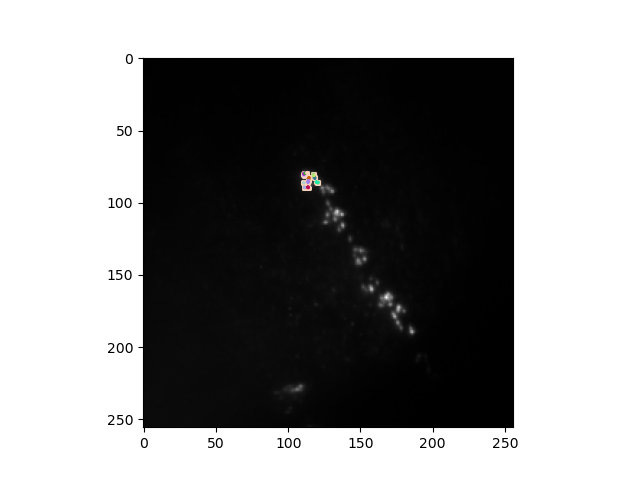

In [24]:
# Load max projection image from raw nd2 video wih Fiji/ImageJ to maintain alignment

Im = plt.imread(max_proj_file)

plot_img_coords_alpha(Im, 0.0015, cluster_data[1], cluster_data[2]) 

plt.savefig('Fig1_v1.svg', format='svg', dpi=300)